In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
gdrive_path = 'gdrive/My Drive/Colab Notebooks/biomed_project'

In [0]:
!pip install pydicom

     |████████████████████████████████| 7.0MB 6.9MB/s 


In [0]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pydicom
import glob
from skimage import io, transform
from sklearn.model_selection import train_test_split
import cv2

import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from scipy.ndimage import binary_dilation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils

In [0]:
def parse_data(df, pre_path=f'{gdrive_path}'):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: list(row[['y', 'x', 'height', 'width']]) #[row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': f'{pre_path}/train_images/{pid}.dcm',
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [0]:
df = pd.read_csv(f'{gdrive_path}/stage_2_train_labels.csv')

parsed = parse_data(df)

In [0]:
df.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [0]:
submission_df = pd.read_csv(f'{gdrive_path}/stage_2_sample_submission.csv')
submission_df.iloc[0]['PredictionString']

'0.5 0 0 100 100'

In [0]:
patientId = df['patientId'][8]
print('Just a checking that everything is working fine...')
print(parsed[patientId])

Just a checking that everything is working fine...
{'dicom': 'gdrive/My Drive/Colab Notebooks/biomed_project/train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm', 'label': 1, 'boxes': [[577.0, 323.0, 104.0, 160.0], [575.0, 695.0, 137.0, 162.0]]}


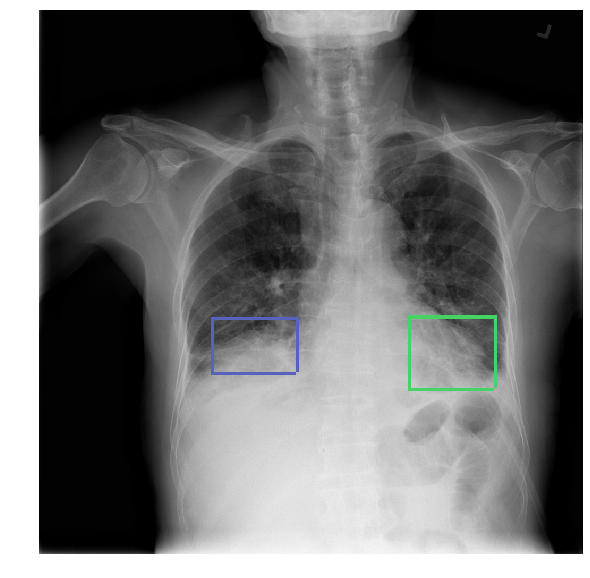

In [0]:
draw(parsed[patientId])

In [0]:
class CXRDataset(Dataset):

    def __init__(self, parsed_dataset, transform=None):
        self.parsed = parsed_dataset
        self.transform = transform
        self.pids = list(self.parsed.keys())

    def __len__(self):
        return len(self.parsed)

    def __getitem__(self, idx):
        pid = self.pids[idx]
        cxr_image = pydicom.read_file(self.parsed[pid]['dicom']).pixel_array
        cxr_image = np.stack([cxr_image] * 3, axis=2)
        
        label = self.parsed[pid]['label']
        boxes = self.parsed[pid]['boxes']

        if self.transform:
            cxr_image = self.transform(cxr_image)
        
        sample = (cxr_image, label, boxes)
        return sample

In [0]:
parsed_train, parsed_val = map(lambda df: df.T.to_dict(), train_test_split(pd.DataFrame(parsed).T, train_size=0.7, test_size=0.3))

In [0]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])


train_dataset = CXRDataset(parsed_train, train_transform)
val_dataset = CXRDataset(parsed_val, val_transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16,)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=16,)

In [0]:
class DenseNet121(nn.Module):
    def __init__(self):
        super(DenseNet121, self).__init__()
        self.model = torchvision.models.densenet121(pretrained=True)
        n_features = self.model.classifier.in_features
        self.model = self.model.features
        self.model.eval()
        self.pre_gap = nn.Sequential(self.model, nn.ReLU())
        
        self.classifier = nn.Linear(n_features, 2)
        
    
    def forward(self, x):
        out = self.pre_gap(x)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    
class LayerActivations():
    
    def __init__(self, model):
        self.hooks = []
        self.hooks.append(model.pre_gap.register_forward_hook(self.hook_fn))
        self.activations = []
    
    def hook_fn(self, module, input, output):
        self.activations.append(output)
    
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [0]:
model = DenseNet121()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [0]:
def accuracy_loss(model, dataloader, n_batches=20, use_cuda=True, calc_loss=False, criterion=None):
    with torch.no_grad():
        acc = 0
        losses = []
        acc_items_len = 0
        for i, (x, y, b) in enumerate(tqdm(dataloader)):
            if use_cuda:
                x, y = x.cuda(), y.cuda()
            
            y_pred = model(x)
            prediction = torch.argmax(y_pred, dim=1)
            if i < n_batches:
                acc_items_len += y.shape[0]
                acc += (prediction == y).sum().to(dtype=torch.float).item()
                if calc_loss:
                    loss = criterion(y_pred, y)
                    losses.append(loss.item())
            else:
                break
            
        acc /= acc_items_len
    if calc_loss:
        return acc, losses
    return acc

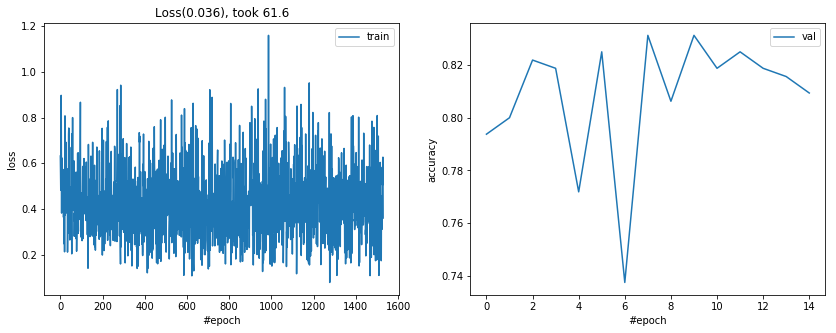

In [0]:
import time
from tqdm import tqdm_notebook as tqdm
from IPython import display

def train(model, train_loader, val_loader, optimizer, criterion, n_epochs=100, use_cuda=True):
    if use_cuda:
        model = model.cuda()
    train_loss_hist = []
    mean_train_loss_hist = []
    val_loss_hist = []
    mean_val_loss_hist = []
    
    best_val_acc = 0
    train_acc_hist = []
    val_acc_hist = []
    
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch + 1, n_epochs))
        print('-' * 10)
        epoch_t = time.time()
        
        train_losses = []
        for i, (x, y, b) in enumerate(tqdm(train_loader)):
            #print(f'at iteration {i}')
            if use_cuda:
                x, y = x.cuda(), y.cuda()
            
            y_pred = model(x)
            loss = criterion(y_pred, y)
            train_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i > 100:
                break
            
        
        #print('calculating metrics...')
        print('Calculating train accuracy')
        train_loss_hist += train_losses
        mean_train_loss = sum(train_losses) / len(train_loader)
        mean_train_loss_hist.append(mean_train_loss)
        #train_acc = accuracy_loss(model, train_loader, use_cuda=use_cuda)
        #train_acc_hist.append(train_acc)
        
        print('Calculating val accuracy')
        #val_acc, val_losses = accuracy_loss(model, val_loader, use_cuda=use_cuda, calc_loss=True, criterion=criterion)
        #val_loss_hist += val_losses
        #mean_val_loss = sum(val_losses) / len(val_loader)
        #mean_val_loss_hist.append(mean_val_loss)
        val_acc = accuracy_loss(model, val_loader, use_cuda=use_cuda, calc_loss=False, criterion=criterion)
        val_acc_hist.append(val_acc)
        
        if val_acc > best_val_acc:
            torch.save(model.state_dict(), 'best_model.pt')

        display.clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))

        #ax[0].set_title(f"Loss({mean_train_loss:.3f}/{mean_val_loss:.3f}), took {time.time() - epoch_t:.1f}")
        ax[0].set_title(f"Loss({mean_train_loss:.3f}), took {time.time() - epoch_t:.1f}")
        ax[0].set_xlabel("#epoch")
        ax[0].set_ylabel("loss")
        ax[0].plot(range(len(train_loss_hist)), train_loss_hist, label='train')
        #val_step = len(train_loss_hist) // len(val_loss_hist)
        #ax[0].plot(range(0, len(val_loss_hist) * val_step, val_step), val_loss_hist, label='val')
        ax[0].legend()
        
        #ax[1].set_title(f"Accuracy({100 * train_acc:.2f}/{100 * val_acc:.2f})")
        ax[1].set_xlabel("#epoch")
        ax[1].set_ylabel("accuracy")
        #ax[1].plot(range(len(train_acc_hist)), train_acc_hist, label='train')
        ax[1].plot(range(len(val_acc_hist)), val_acc_hist, label='val')
        
        ax[1].legend()
        plt.show()
        
        #print(f'epoch: {epoch}, train loss: {mean_train_loss:.5f}, test loss: {mean_val_loss}')
        #print(f'epoch: {epoch}, train loss: {mean_train_loss:.5f}')
        #print(f'train acc: {100 * train_acc:.2f}%, val acc: {100 * val_acc:.2f}%, took: {time.time() - epoch_t:.2f} sec')
        
        
    model.load_state_dict(torch.load('best_model.pt'))
    return train_loss_hist, mean_train_loss_hist, val_loss_hist, mean_val_loss_hist

results = train(model, train_loader, val_loader, optimizer, criterion, n_epochs=15, use_cuda=True)

In [0]:
model.eval()

train_acc = accuracy_loss(model, train_loader, use_cuda=True, n_batches=len(train_loader), calc_loss=False, criterion=criterion)
val_acc = accuracy_loss(model, val_loader, use_cuda=True, n_batches=len(val_loader), calc_loss=False, criterion=criterion)

print(f'train acc: {100 * train_acc:.2f}%, val acc: {100 * val_acc:.2f}%')

train acc: 80.34%, val acc: 81.04%


In [0]:
model.load_state_dict(torch.load('best_model.pt'))
model.cuda()
model.eval()

DenseNet121(
  (model): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
def IandU(xywh1, xywh2):
    x1, y1, w1, h1 = xywh1
    x2, y2, w2, h2 = xywh2

    dx = min(x1+w1, x2+w2) - max(x1, x2)
    dy = min(y1+h1, y2+h2) - max(y1, y2)
    intersection = dx * dy if (dx >=0 and dy >= 0) else 0.
    
    union = w1 * h1 + w2 * h2 - intersection
    return intersection, union


def multibox_iou(boxes_pred, boxes_true):
    total_intersection = 0
    total_union = 0
    
    for box_true in boxes_true:
        total_union += box_true[2] * box_true[3]
        for box_pred in boxes_pred:
            intersection, _ = IandU(box_true, box_pred)
            total_intersection += intersection
    for box_pred in boxes_pred:
        total_union += box_pred[2] * box_pred[3]
    return total_intersection / total_union

In [0]:
def predict(model, dataset, use_cuda=True, idx_min=0, idx_max=None):
    res_df = {}
    ious = []
    boxes_list = []
    
    W = model.classifier.weight
    
    neighborhood_size = 100
    threshold = .1
    intensity_th = 0.9
    
    if idx_max is None:
        idx_max = range(len(dataset)) -1 
        
    for i, (x, y, b) in enumerate(dataset):
        if i < idx_min:
            continue
        elif i >= idx_max:
            break
        acts = LayerActivations(model) 
        if use_cuda:
            x = x.cuda()
        scores = model(x.unsqueeze(0)).cpu()
        x = x.cpu()
        pred = torch.argmax(scores, dim=1).item()
        pneumonia_prob = nn.Softmax(dim=1)(scores).squeeze(0)[pred].item()
        pid = dataset.pids[i]
        
        boxes = []
        if pred:
            #predict boxes for pneumonia
            out_features = acts.activations[0].squeeze(0)
            out_features = np.transpose(out_features.cpu().detach(),(1,2,0))
            
            w = W[pred, :]

            cam = np.dot(out_features, w.cpu().detach())
            data = cv2.resize(cam, (1024, 1024))

            data_max = filters.maximum_filter(data, neighborhood_size)
            maxima = (data == data_max)
            data_min = filters.minimum_filter(data, neighborhood_size)
            diff = ((data_max - data_min) > threshold)
            maxima[diff == 0] = 0
            for _ in range(5):
                maxima = binary_dilation(maxima)

            labeled, num_objects = ndimage.label(maxima)
            slices = ndimage.find_objects(labeled)
            xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))

            thresholded_data = (data > np.max(data)*intensity_th).astype(np.int)

            for point in xy:
                centroid_x = int(point[0])
                centroid_y = int(point[1])

                if data[centroid_x, centroid_y] > np.max(data)*intensity_th:
                    # find box boundaries
                    left, right, upper, lower = centroid_x, centroid_x, centroid_y, centroid_y

                    while left > 0 and thresholded_data[max(0,left), centroid_y] == 1:
                        left -= 1
                    while right < thresholded_data.shape[0] and thresholded_data[min(thresholded_data.shape[0],right), centroid_y] == 1:
                        right += 1
                    while lower > 0 and thresholded_data[centroid_x, max(0,lower)] == 1:
                        lower -= 1
                    while upper < thresholded_data.shape[1] and thresholded_data[centroid_x, min(thresholded_data.shape[1],upper)] == 1:
                        upper += 1
                    boxes.append([left, lower, right - left, upper - lower])
            
            iou = multibox_iou(boxes, b)
            ious.append(iou)
                    
            res_df[pid] = ' '.join([f'{pneumonia_prob} {box[0]} {box[1]} {box[2]} {box[3]}' for box in boxes])
        else:
            res_df[pid] = np.nan
            
        boxes_list.append(boxes)
    return res_df, boxes_list, ious

In [0]:
res_df, boxes_list, ious = predict(model, val_dataset, idx_min=100, idx_max=200)

In [0]:
ious = np.array(ious)

In [0]:
matplotlib.rcParams['backend'] = 'TkAgg' 

def draw_pred(im, box_true, box_pred, title, save=False, savename=None):
    """
    Method to draw single patient with bounding box(es) if present 

    """

    # --- Add boxes with random color if present
    for box in box_true:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)
    
    for box in box_pred:
        #rgb = np.floor(np.ones(3) * 256).astype('int')
        rgb = np.array([255, 0, 0])
        #rgb = np.floor(np.random.rand(3) * 256).astype('int')
        
        stroke = 6
        left = box[0]
        lower = box[1]
        right = left + box[2]
        upper = lower + box[3]

        im[left:left + stroke, lower:upper] = rgb
        im[right:right + stroke, lower:upper] = rgb
        im[left:right, lower:lower + stroke] = rgb
        im[left:right, upper:upper + stroke] = rgb
        #im = overlay_box(im, box, rgb, stroke=6)
        
    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(title)
    if save:
        plt.savefig(savename, format='png')
    else:
        plt.imshow(im, cmap=plt.cm.gist_gray)
        plt.show()

In [0]:
!rm model_pics/*.png
!rmdir model_pics
!mkdir model_pics


In [0]:
!zip -r pics.zip model_pics

In [0]:
details = pd.read_csv(f'{gdrive_path}/stage_2_detailed_class_info.csv')
details.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [0]:
details.describe()

patientId                         class
count                                  30227                         30227
unique                                 26684                             3
top     0d5bc737-03de-4bb8-98a1-45b7180c3e0f  No Lung Opacity / Not Normal
freq                                       4                         11821

In [0]:
(details['class'] == 'Lung Opacity').sum()

9555

In [0]:
not_normal = 11821
normal = 8851
opacity = 9555

s = not_normal + normal + opacity

In [0]:
not_normal / s

0.3910742051807986

In [0]:
normal / s

0.292817679558011

In [0]:
opacity /  s

0.3161081152611903

In [0]:
20672
9555

20672

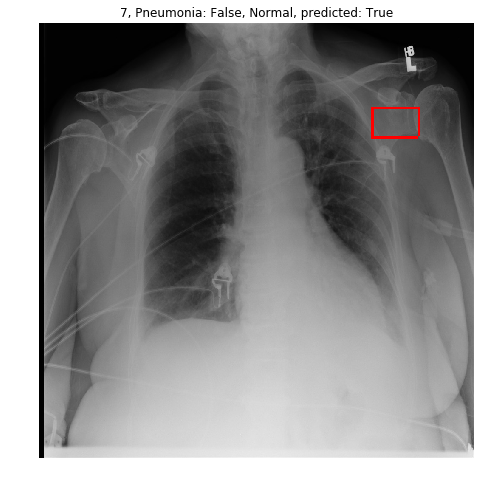

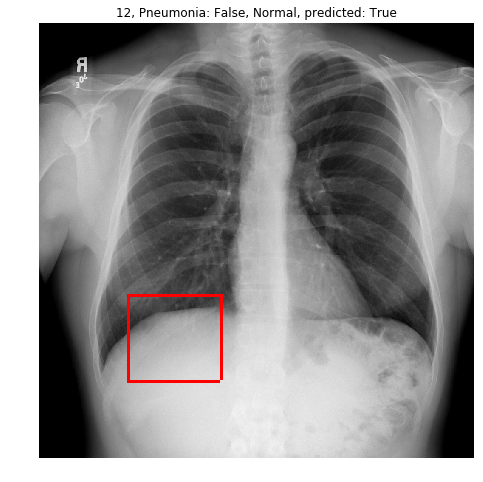

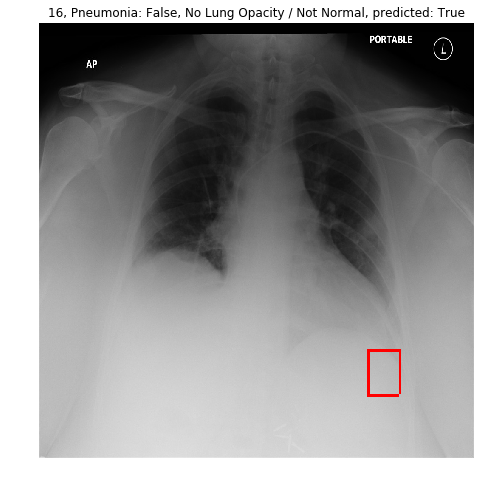

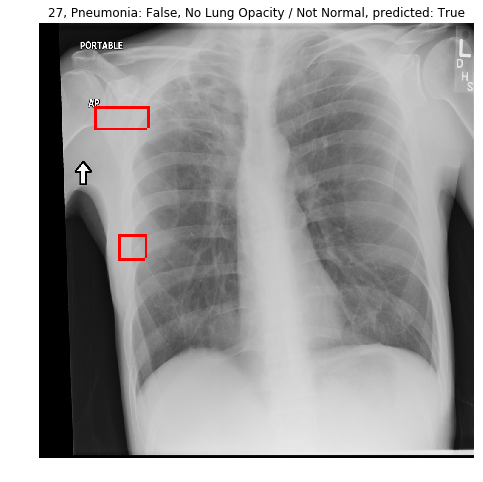

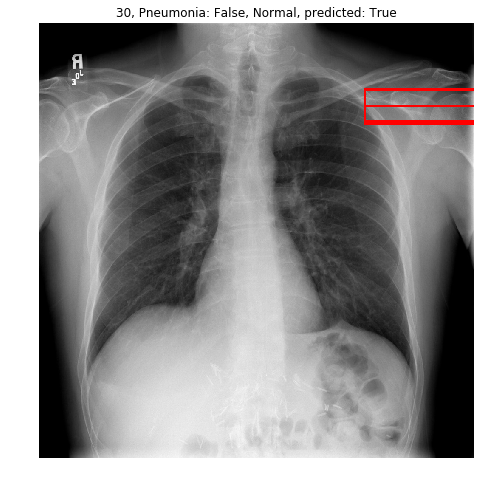

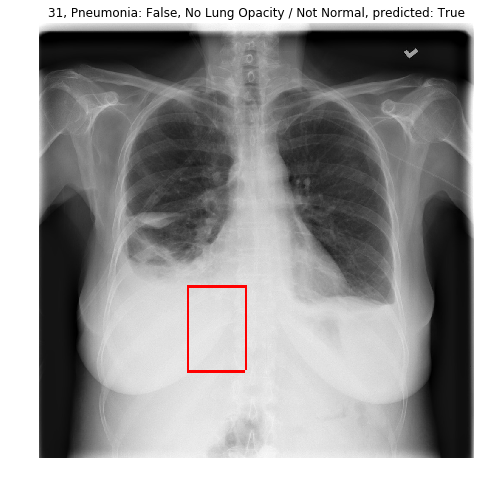

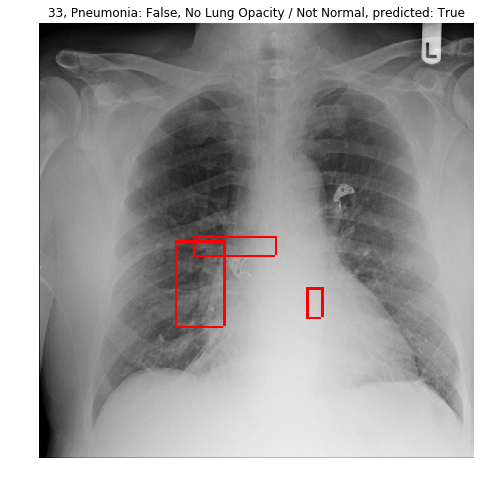

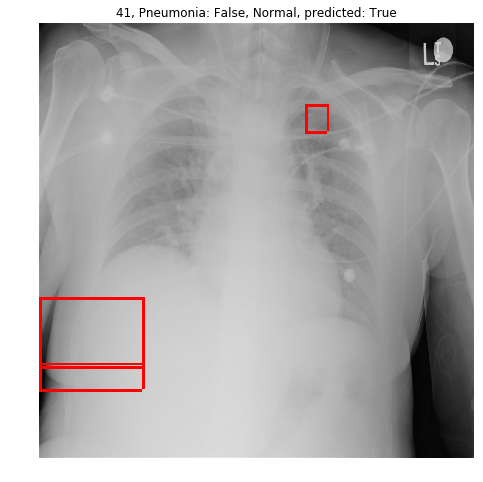

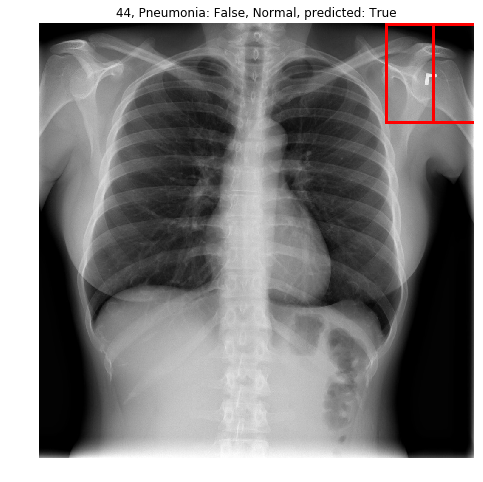

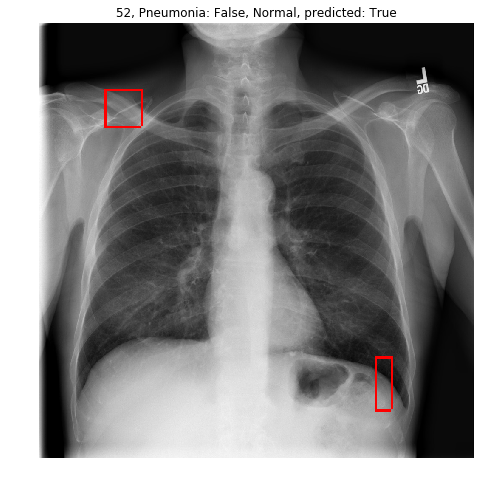

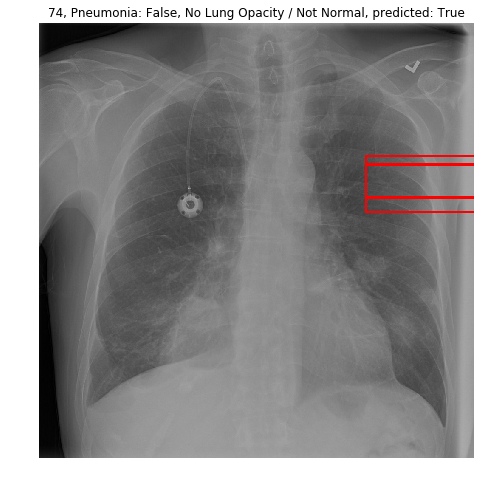

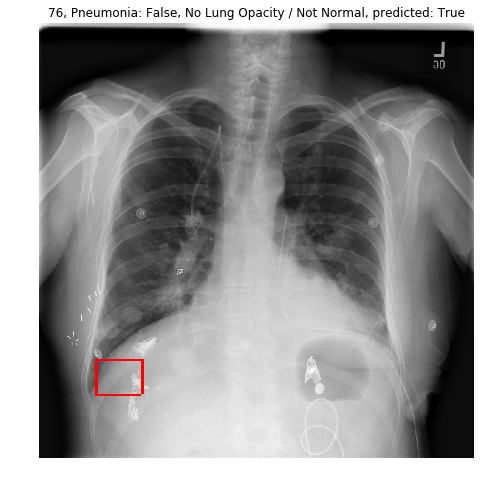

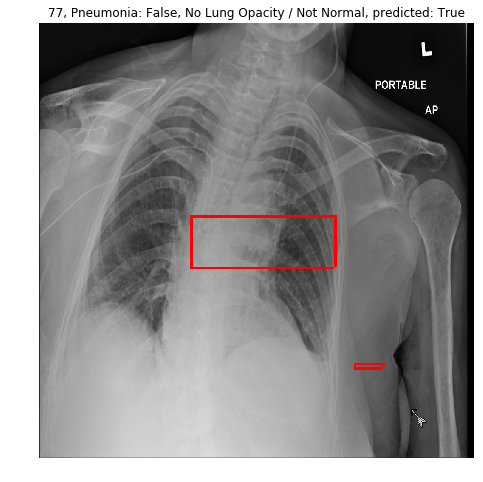

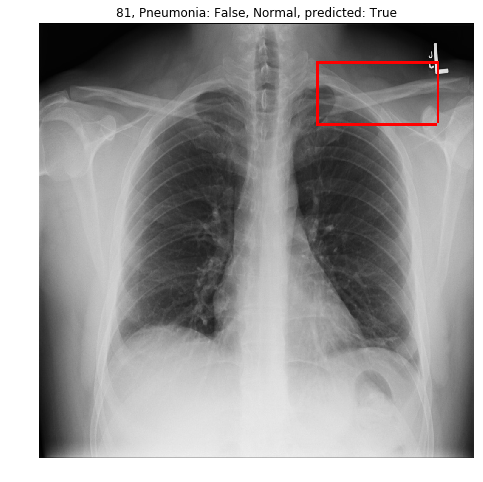

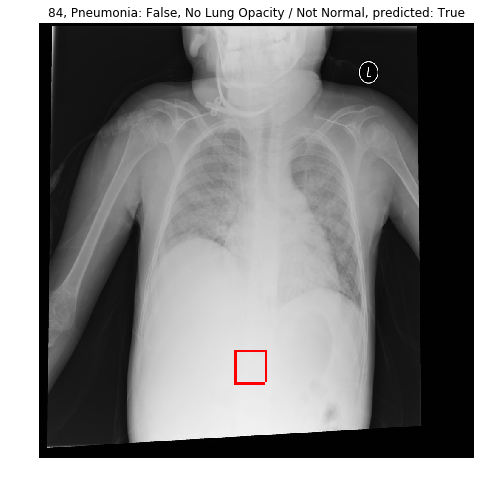

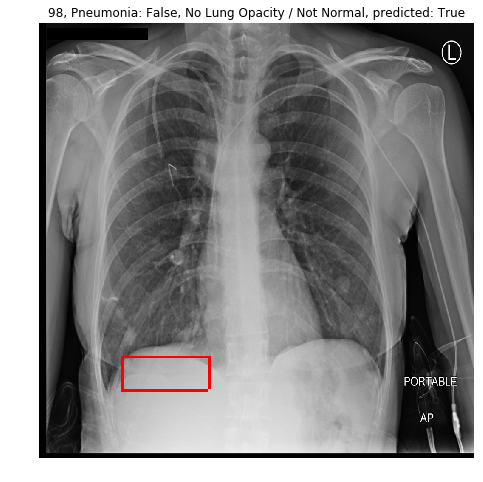

In [0]:
val_pids = val_dataset.pids

for i in range(100):
    pid = val_pids[i]
    im = np.stack([pydicom.read_file(parsed[pid]['dicom']).pixel_array] * 3, axis=2)
    true_classes = details[details['patientId'] == pid]['class']
    true_class = '|'.join([i for i in true_classes])
    
    has_pneumonia = parsed_val[pid]["label"] == 1
    predicted_pneumonia = len(boxes_list[i]) > 0
    
    if predicted_pneumonia and not has_pneumonia:
        draw_pred(im, 
                  parsed_val[pid]['boxes'], 
                  boxes_list[i], 
                  f'{i}, Pneumonia: {has_pneumonia}, {true_class}, predicted: {predicted_pneumonia}', 
                  save=False, 
                  savename=f'model_pics/pic_{i}.png')
    

In [0]:
idx=66
acts = LayerActivations(model) 
img = val_dataset[idx][0].view(1, 3, 224, 224)
pid = val_dataset.pids[idx]
scores = model(img.cuda())

out_features = acts.activations[0].squeeze(0) #since we have performed a forward pass through our model, we can obtain activations from layer(model.layer4) defined in the LayerActivation class from the features list and take out the batch dimension.
out_features = np.transpose(out_features.cpu().detach(),(1,2,0)) # Changes shape from 2048 x 7 x7 to 7 x 7 x 2048. Just performs a matrix transpose on the output features tensor.

pred = np.argmax(scores.cpu().detach()) #Obtain the axis of the predicted class.
W = model.classifier.weight #We obtain all the weights connecting the Global Average Pooling layer to the final fully connected layer.
w = W[pred,:] # We obtain the weights associated with the predicted class which is a 2048 dimensional vector.

from scipy.ndimage import zoom

cam = np.dot(out_features.detach(),w.detach().cpu())
class_activation = cv2.resize(cam, (1024, 1024))

In [0]:
for i in range(100, 300):
    pid = val_dataset.pids[i]
    if parsed_val[pid]['label'] == 1:
        print(i)
        break

106


(-0.5, 1023.5, 1023.5, -0.5)

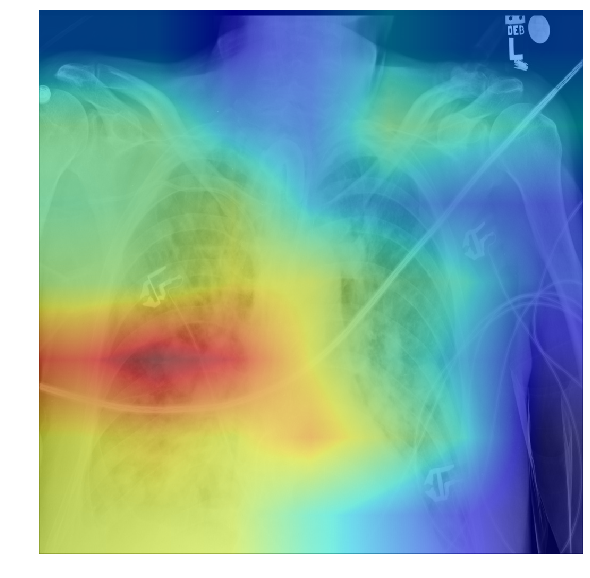

In [0]:
neighborhood_size = 100
threshold = .1
intensity_th = 0.85

data = cv2.resize(class_activation, (1024, 1024))
data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0
for _ in range(5):
    maxima = binary_dilation(maxima)

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))

thresholded_data = (data > np.max(data)*intensity_th).astype(np.int)

boxes = []

for point in xy:
    centroid_x = int(point[0])
    centroid_y = int(point[1])
    
    if data[centroid_x, centroid_y] > np.max(data)*intensity_th:
        # find box boundaries
        left, right, upper, lower = centroid_x, centroid_x, centroid_y, centroid_y

        while left > 0 and thresholded_data[max(0,left), centroid_y] == 1:
            left -= 1
        while right < thresholded_data.shape[0] and thresholded_data[min(thresholded_data.shape[0],right), centroid_y] == 1:
            right += 1
        while lower > 0 and thresholded_data[centroid_x, max(0,lower)] == 1:
            lower -= 1
        while upper < thresholded_data.shape[1] and thresholded_data[centroid_x, min(thresholded_data.shape[1],upper)] == 1:
            upper += 1
            
        boxes.append([left, lower, right - left, upper - lower])
    
    # --- Extract coordinates
    #rgb = np.floor(np.random.rand(3) * 256).astype('int')
    

th_data_rgb = np.stack([thresholded_data * 256] * 3, axis=2)

for box in boxes:
    #rgb = np.floor(np.random.rand(3) * 256).astype('int')
    rgb = np.array([255, 0, 0])
    
    left = box[0]
    lower = box[1]
    right = left + box[2]
    upper = lower + box[3]
    
    stroke = 5
    th_data_rgb[left:left + stroke, lower:upper] = rgb
    th_data_rgb[right:right + stroke, lower:upper] = rgb
    th_data_rgb[left:right, lower:lower + stroke] = rgb
    th_data_rgb[left:right, upper:upper + stroke] = rgb
    
plt.figure(figsize=(10, 10))
im = np.stack([pydicom.read_file(parsed[pid]['dicom']).pixel_array] * 3, axis=2)
plt.imshow(im, cmap='jet',alpha=1)
#draw(parsed_val[pid])
plt.imshow(class_activation, cmap='jet', alpha=.5)
#plt.imshow(th_data_rgb, cmap='jet', alpha=.5)
plt.axis('off')

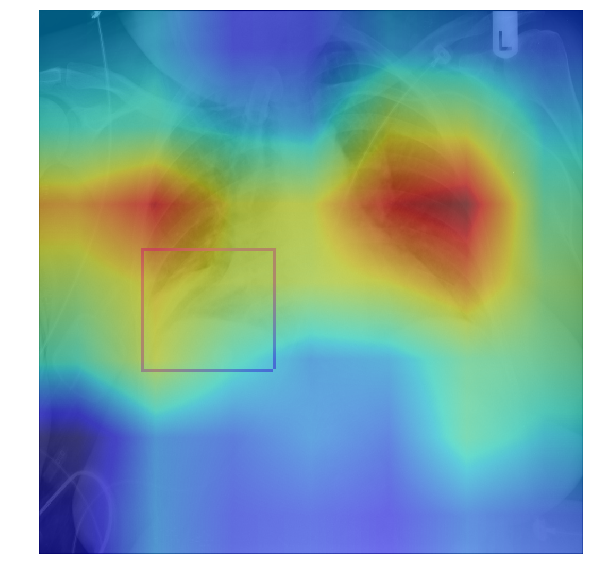

In [0]:
draw(parsed_val[pid])
plt.imshow(class_activation, cmap='jet', alpha=.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


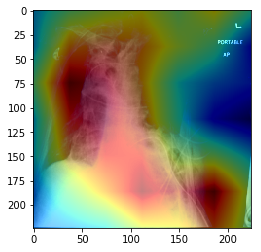

In [0]:
img = img[0] #removes the batch dimension from the input image (1x3x224x224) to (3x224x224)
img = np.transpose(img,(1,2,0)) #matplotlib supports channel-last dimensions so we perform a transpose operation on our image which changes its shape to (224x224,3)

#we plot both input image and class_activation below to get our desired output.
plt.imshow(img, cmap='jet',alpha=1)  #jet indicates that color-scheme we are using and alpha indicates the intensity of the color-scheme
plt.imshow(class_activation,cmap='jet',alpha=0.5)

(-0.5, 1023.5, 1023.5, -0.5)

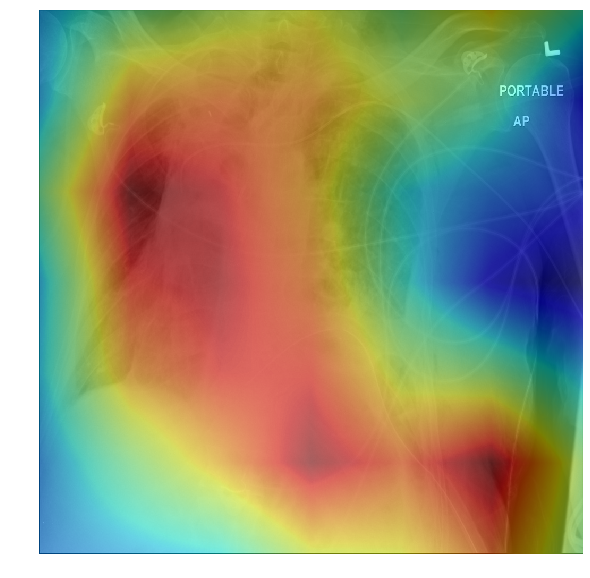

In [0]:
im = np.stack([pydicom.read_file(parsed[pid]['dicom']).pixel_array] * 3, axis=2)

plt.figure(figsize=(10, 10))
plt.imshow(im, cmap='jet',alpha=1)
plt.imshow(cv2.resize(class_activation, (1024, 1024)), cmap='jet',alpha=.5)
plt.axis('off')

In [0]:
import os

class CXRTestDataset(Dataset):

    def __init__(self, path, transform=None):
        self.path = path
        self.pids = list(map(lambda s: s.split('.')[-2], os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.pids)

    def __getitem__(self, idx):
        pid = self.pids[idx]
        cxr_image = pydicom.read_file(f'{self.path}/{pid}.dcm').pixel_array
        cxr_image = np.stack([cxr_image] * 3, axis=2)
        if self.transform:
            cxr_image = self.transform(cxr_image)
            
        return cxr_image
    

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

test_dataset = CXRTestDataset(f'{gdrive_path}/test_images', val_transform)


In [0]:
len(test_dataset)

3012